# Looking at autocorrelations of residuals to check if predictions can be improved upon

#### Predictions for time series are done (here with exponential smoothing), but can they be improved upon?
This can be checked by looking at the correlogram (= autocorrelations). <br>
If there are correlations between lags, then you could still improve your prediction

#### Prediction upper and lower limits can be calculated, when:
- autocorrelations between forecasting errors/residuals are zero, 
- and errors are normally distributed with mean 0 and constanct variance $\sigma^2$, so $E_t \sim N(0,\sigma^2)$ 

#### Both pandas as well as statsmodels can plot autocorrelation. Which is the correct one to use? Statsmodels gives the same result as SPSS.

In [1]:
# getting some warnings from matplotlib, so turning those warnings off
import warnings
warnings.filterwarnings('ignore')

# importing libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
from statsmodels.stats.diagnostic import acorr_ljungbox

# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html
from statsmodels.tsa.stattools import acf

# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html#statsmodels-graphics-tsaplots-plot-pacf
from statsmodels.graphics.tsaplots import plot_acf

# https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot
from pandas.plotting import autocorrelation_plot

In [3]:
# reading csv to dataframe
filename = './data/airline6.csv'
df = pd.read_csv(filename)

In [4]:
# set year as period_index, drop some unnecessary columns
df = (
    df.assign(year=pd.PeriodIndex(df['DATE_'], freq='Y'))
      .set_index('year')
      .drop(columns=['YEAR_', 'DATE_'])
)

In [5]:
# forecast was already done
df.head(3)

,passengers,fpass,forecast,error
year,,,,
1949,1839344.000,36.827,36.827,0.000
1950,2132542.000,38.214,38.313,-0.099
1951,2471044.000,39.648,39.700,-0.052


In [6]:
# there are predictions for years 2000 and on.
df.tail(6)

,passengers,fpass,forecast,error
year,,,,
1999,168477753.000,113.929,113.780,0.150
2000,nan,nan,115.418,nan
2001,nan,nan,116.906,nan
2002,nan,nan,118.395,nan
2003,nan,nan,119.883,nan
2004,nan,nan,121.371,nan


#### Errors should be normally distributed with mean 0 and constant variance and no autocorrelations, otherwise the predictions can be improved upon.

In [7]:
# error has mean near 0
df.error.mean()

0.052158416315479385

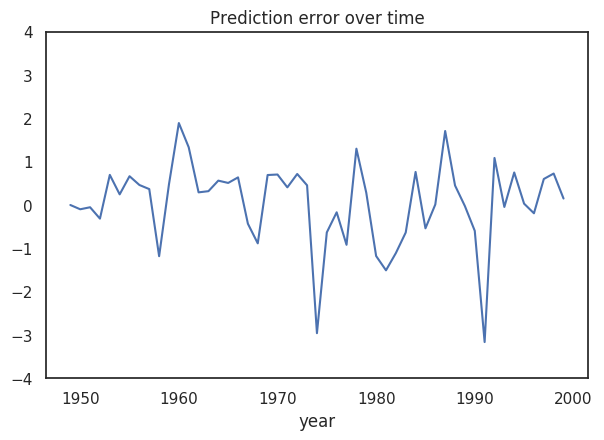

In [8]:
# error looks like it has constant variance
ax = df.error.plot(title='Prediction error over time')
ax.set(ylim=(-4.0,4.0));

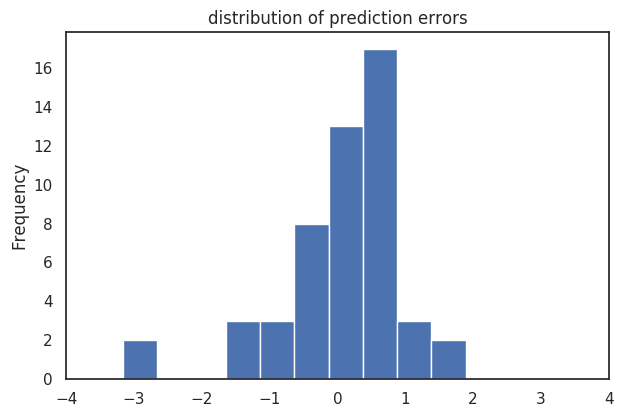

In [9]:
# hard to tell if this is a normal distribution, let's say it is
ax = df.error.plot(kind='hist')
ax.set(xlim=(-4.0, 4.0), title='distribution of prediction errors');

#### Simple significance bounds for the correlogram can be calculated by:
$\pm 1.96 \cdot 1 / \sqrt{N}$ In this dataset N=51. <br>
I have added these significance bounds to the correlogram below

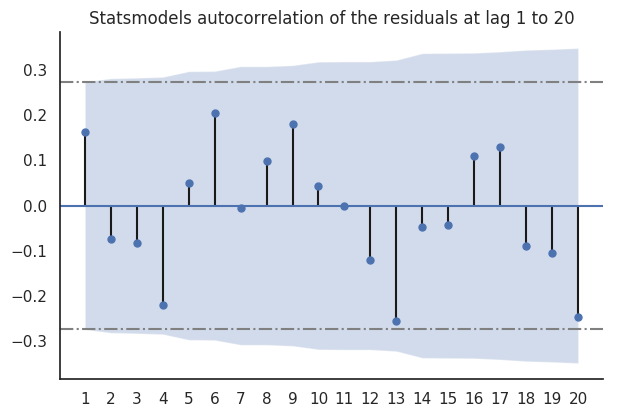

In [23]:
# plotting the autocorrelations with the correlogram from statsmodels
# all autocorrelation values stay within the confidence limits, so no evidence for autocorrelation
# confidence intervals in statsmodels acf plot for the autocorrelations are calculated using Bartletts approximation
fig, ax = plt.subplots(1,1)

plot_acf(
    df['error'].loc[:'1999'], # plotting only works if you take non nan values
    lags=20, # plot 20 lags
    zero=False, # don't take lag 0, which results in 1.0 anyways
    unbiased=False, # to get the same results as SPSS
    ax=ax, # to add this plot to current ax
    title='Statsmodels autocorrelation of the residuals at lag 1 to 20'
);

# add some extra simple confidence intervals
simple_sign_bound_upper = 1.96 * 1/np.sqrt(51)
simple_sign_bound_lower = -1 * 1.96 * 1/np.sqrt(51)
plt.axhline(y=simple_sign_bound_upper, color='grey', linestyle='-.')
plt.axhline(y=simple_sign_bound_lower, color='grey', linestyle='-.')

# get some decent xticks
plt.xticks(ticks=range(1,21), labels=range(1,21))

sns.despine();

In [11]:
# how to get the autocorrelation data out of the plot:
autocorr_in_plot = ax.lines[1].get_data()[1]
autocorr_in_plot

array([ 0.16276543, -0.07348921, -0.08228492, -0.21928837,  0.05082054,
        0.20453462, -0.00510728,  0.09772937,  0.18127116,  0.04405413,
       -0.00065159, -0.12109608, -0.25501929, -0.04826111, -0.04240011,
        0.11019528,  0.13058974, -0.09015213, -0.10570151, -0.24745277])

In [12]:
# check if there are significant autocorrelations among the error lags by:
# calculating ljung box test statistic and corresponding p values
# https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
test_statistic_ljung_box, p_value_lags = acorr_ljungbox(df['error'].loc[:'1999'], lags=20)

In [13]:
# ljung box value for lag 20 is 25.576
test_statistic_ljung_box

array([ 1.43218922,  1.73010746,  2.11138861,  4.87692508,  5.02868837,
        7.54154192,  7.54314433,  8.14352652, 10.2582528 , 10.3862014 ,
       10.38623009, 11.40257607, 16.02860678, 16.19875952, 16.33374202,
       17.2715286 , 18.62729626, 19.29300467, 20.23675791, 25.57586945])

In [14]:
# p value at lag 20 is 0.180, so little or no evidence for autocorrelation
p_value_lags

array([0.23140749, 0.42102893, 0.54961221, 0.30016045, 0.41238907,
       0.2736504 , 0.37459476, 0.41957718, 0.3299857 , 0.40728844,
       0.49601624, 0.4947688 , 0.24758855, 0.30138758, 0.36022438,
       0.36824049, 0.35033953, 0.37399288, 0.38045992, 0.18028082])

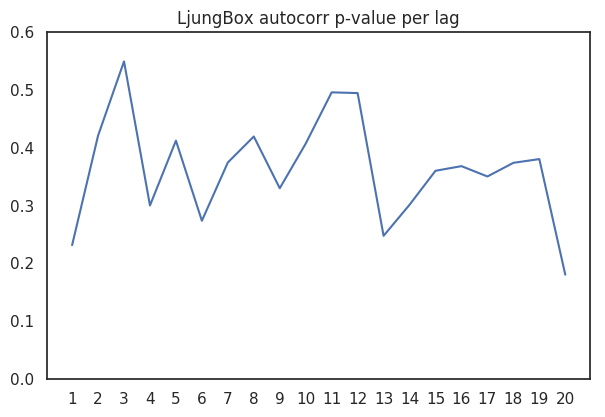

In [15]:
# just checking for fun how the ljung box p values develop over the lags
# although normally you would only have to look the pvalue of the last lag
ax = sns.lineplot(x=range(1,21), y=p_value_lags)
ax.set(ylim=(0,0.6), title='LjungBox autocorr p-value per lag')
plt.xticks(ticks=range(1,21), labels=range(1,21));

In [16]:
# calculate autocorrelations for the errors
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html
acf_, confint, qstat, pvalues = acf(
    df['error'].loc[:'1999'], 
    nlags=20, 
    alpha=0.05, 
    qstat=True, # also calculate LjungBox test statistic
    unbiased=False
)

In [17]:
# autocorrelations of the errors per lag
acf_[1:]

array([ 0.16276543, -0.07348921, -0.08228492, -0.21928837,  0.05082054,
        0.20453462, -0.00510728,  0.09772937,  0.18127116,  0.04405413,
       -0.00065159, -0.12109608, -0.25501929, -0.04826111, -0.04240011,
        0.11019528,  0.13058974, -0.09015213, -0.10570151, -0.24745277])

In [24]:
# conf interval of the autocorrelations
confint[1:]

array([[-0.11168442,  0.43721529],
       [-0.35511611,  0.20813769],
       [-0.36535257,  0.20078273],
       [-0.504152  ,  0.06557526],
       [-0.24648643,  0.34812751],
       [-0.09342596,  0.5024952 ],
       [-0.31346206,  0.3032475 ],
       [-0.21063178,  0.40609053],
       [-0.12941425,  0.49195656],
       [-0.27449808,  0.36260635],
       [-0.31966237,  0.3183592 ],
       [-0.44010696,  0.19791481],
       [-0.57747401,  0.06743544],
       [-0.3855655 ,  0.28904328],
       [-0.38022421,  0.295424  ],
       [-0.22802942,  0.44841999],
       [-0.21032848,  0.47150797],
       [-0.43481761,  0.25451336],
       [-0.4521386 ,  0.24073558],
       [-0.5963106 ,  0.10140506]])

In [19]:
# ljung box test statistic for 20 lags
qstat

array([ 1.43218922,  1.73010746,  2.11138861,  4.87692508,  5.02868837,
        7.54154192,  7.54314433,  8.14352652, 10.2582528 , 10.3862014 ,
       10.38623009, 11.40257607, 16.02860678, 16.19875952, 16.33374202,
       17.2715286 , 18.62729626, 19.29300467, 20.23675791, 25.57586945])

In [20]:
# p values that belong to ljung box test statistic for 20 lags
pvalues

array([0.23140749, 0.42102893, 0.54961221, 0.30016045, 0.41238907,
       0.2736504 , 0.37459476, 0.41957718, 0.3299857 , 0.40728844,
       0.49601624, 0.4947688 , 0.24758855, 0.30138758, 0.36022438,
       0.36824049, 0.35033953, 0.37399288, 0.38045992, 0.18028082])

In [25]:
# this calculation of autocorrelations agrees with SPSS
acf(df['error'].loc[:'1999'], nlags=20, unbiased=False)[1:]

array([ 0.16276543, -0.07348921, -0.08228492, -0.21928837,  0.05082054,
        0.20453462, -0.00510728,  0.09772937,  0.18127116,  0.04405413,
       -0.00065159, -0.12109608, -0.25501929, -0.04826111, -0.04240011,
        0.11019528,  0.13058974, -0.09015213, -0.10570151, -0.24745277])

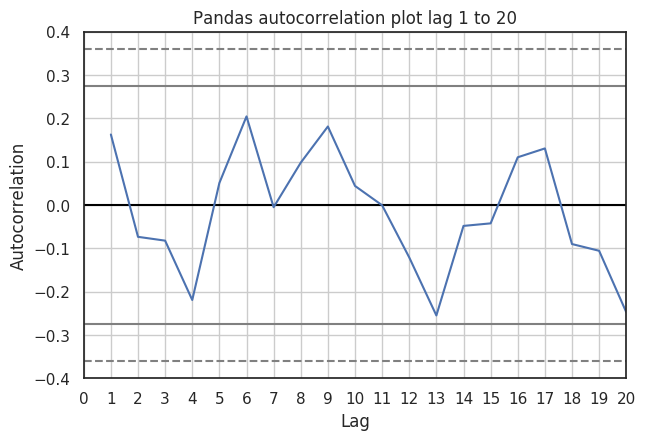

In [26]:
# example of pandas autocorrelation plot, numbers are different
ax = autocorrelation_plot(df['error'].loc[:'1999'])
ax.set(ylim=(-0.4,0.4), xlim=(0,20), title='Pandas autocorrelation plot lag 1 to 20')
plt.xticks(ticks=range(0,21), labels=range(0,21));

In [35]:
# pandas autocorrelation
ax.lines[5].get_data()[1][0:20]

array([ 0.16276543, -0.07348921, -0.08228492, -0.21928837,  0.05082054,
        0.20453462, -0.00510728,  0.09772937,  0.18127116,  0.04405413,
       -0.00065159, -0.12109608, -0.25501929, -0.04826111, -0.04240011,
        0.11019528,  0.13058974, -0.09015213, -0.10570151, -0.24745277])

#### Which calculation of autocorrelation at lag x is better? Pandas or Statsmodels?
Seems like statsmodels is better. Although the calculations in the plots above give the same result.
There are sometimes serious differences, check this post on Stackoverflow:
https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf